# Sujet
Le client gère des distributeurs de boissons sur des quais de gare. Un employé passe une fois par semaine recharger les machines. Cet employé indique régulièrement que la machine était vide, mais sans préciser quels produits sont vides. Le client souhaiterait estimer le manque à gagner (lorsqu'il y a rupture de stock), et te demande une analyse détaillée. Il aimerait un conseil pour savoir s'il est rentable d'envoyer ou non l'employé pour recharger les machines deux fois par semaine plutôt qu'une seule fois.

Pour cela, il te fournit l'extraction du journal automatique (le "log") des 4 distributeurs de boisson de la gare concernée. Chaque machine enregistre en effet chaque vente ou passage du technicien avec un horodatage.

 

Quelques compléments (tous les montants sont hors taxe, tu n'as donc pas à prendre en compte les taxes et/ou les impôts dans cette analyse) :

Le déplacement d'un employé coûte 50 euros pour aller à la gare + 20 euros par machine. Les 4 machines sont dans la même gare.
Le prix de vente des boissons est de : 1 euro le café ; 1,60 euros le soda ; 1,80 euros le nrj drink.
Le coût de revient des boissons est de : 30 cts le café ; 60 cts le soda ; 80 cts le nrj drink.
Chaque distributeur a une capacité maximale de : 280 doses de café ; 120 canettes de soda ; 60 bouteilles de nrj drink.
La gare est fermée au public une partie de la nuit.
Le coût de location de l'emplacement pour chaque machine est de 150 euros mensuels.
Les frais d'entretien de chaque machine sont de 1200 euros annuels.

# Préparation des données

## 1_ Import

In [1]:
import time
import json 
import numpy as np
import pandas as pd
import datetime
import regex as re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
with open(r"C:\Users\manon\Dev\2023_boissons\beverage_dispenser.json") as f:
    data = json.load(f)

## 2_ Création dataframe

In [3]:
# impression uniquement des 10 premieres lignes 
for x in data["content"][:10] : 
    print (x)

{'date': '2019-11-14T11:53:35.000Z', 'product': 'refill', 'machine': 'A'}
{'date': '2019-11-14T12:06:35.000Z', 'product': 'coffee', 'machine': 'A'}
{'date': '2019-11-14T12:07:59.000Z', 'product': 'soda', 'machine': 'A'}
{'date': '2019-11-14T12:13:45.000Z', 'product': 'soda', 'machine': 'A'}
{'date': '2019-11-14T12:22:35.000Z', 'product': 'coffee', 'machine': 'A'}
{'date': '2019-11-14T12:37:44.000Z', 'product': 'soda', 'machine': 'A'}
{'date': '2019-11-14T12:47:09.000Z', 'product': 'refill', 'machine': 'B'}
{'date': '2019-11-14T12:47:52.000Z', 'product': 'coffee', 'machine': 'A'}
{'date': '2019-11-14T12:51:00.000Z', 'product': 'coffee', 'machine': 'A'}
{'date': '2019-11-14T12:52:49.000Z', 'product': 'coffee', 'machine': 'A'}


In [4]:
df_init = pd.json_normalize(data["content"])

## 3_ NaN & duplicated

In [5]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11042 entries, 0 to 11041
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     11042 non-null  object
 1   product  11042 non-null  object
 2   machine  11042 non-null  object
dtypes: object(3)
memory usage: 258.9+ KB


In [6]:
df_init.duplicated().sum()

6

In [7]:
df_init[df_init.duplicated()]

,date,product,machine
125,2019-11-14T19:04:03.000Z,soda,D
1495,2019-11-18T12:25:36.000Z,coffee,D
2032,2019-11-22T05:09:25.000Z,coffee,A
2070,2019-11-22T06:40:28.000Z,coffee,A
5012,2019-12-02T08:32:20.000Z,coffee,B
8308,2019-12-14T18:40:49.000Z,nrj,B


In [8]:
df_init.drop_duplicates(inplace=True)

In [9]:
df_init

,date,product,machine
0,2019-11-14T11:53:35.000Z,refill,A
1,2019-11-14T12:06:35.000Z,coffee,A
2,2019-11-14T12:07:59.000Z,soda,A
3,2019-11-14T12:13:45.000Z,soda,A
4,2019-11-14T12:22:35.000Z,coffee,A
...,...,...,...
11037,2019-12-25T20:10:53.000Z,nrj,A
11038,2019-12-25T20:16:30.000Z,nrj,B
11039,2019-12-25T20:26:35.000Z,nrj,B
11040,2019-12-25T21:11:55.000Z,nrj,B


In [10]:
df_init = df_init.sort_values("date").reset_index(drop=True).copy(deep=True)

In [11]:
df_init["date"] = pd.to_datetime(df_init["date"])

In [12]:
df_init["date"].dt.hour

0        11
1        12
2        12
3        12
4        12
         ..
11031    20
11032    20
11033    20
11034    21
11035    21
Name: date, Length: 11036, dtype: int32

## 4_ date_donnée : Produits, tarifs, fees

In [13]:
# details = {date_concernee, [[nom_item1, prix_de_vente, prix_achat, capacite_machine], [nom_item2, prix_de_vente, ...], ... ]}
details_produits = {"2023-11" : {"coffee" : [1, 0.3, 280], "soda" : [1.6, 0.6, 120], "nrj" : [1.8, 0.8, 60]}}

In [14]:
details_produits["2023-11"]

{'coffee': [1, 0.3, 280], 'soda': [1.6, 0.6, 120], 'nrj': [1.8, 0.8, 60]}

In [15]:
details_produits["2023-11"].keys()

dict_keys(['coffee', 'soda', 'nrj'])

In [16]:
details_produits["2023-11"]["coffee"]

[1, 0.3, 280]

In [17]:
# Le coût de location de l'emplacement pour chaque machine est de 150 euros mensuels.
# Les frais d'entretien de chaque machine sont de 1200 euros annuels.
# Le déplacement d'un employé coûte 50 euros pour aller à la gare + 20 euros par machine. Les 4 machines sont dans la même gare.

## 5_ Initialisation suivi temporel

In [18]:
identifiants_machines = list(df_init["machine"].unique())
identifiants_machines

['A', 'B', 'C', 'D']

In [19]:
produits = list(details_produits["2023-11"].keys())
produits

['coffee', 'soda', 'nrj']

In [20]:
def creation_colonnes(df, liste_id_machines, liste_produits) :
    
    jour = {1: "monday", 2:"tuesday", 3 : "wednesday", 4 : "thursday", 5 : "friday", 6 : "saturday", 7 : "sunday"}
    df["month"]=df["date"].dt.month
    df["day"]=df["date"].dt.day
    df["weekday"]=df["date"].dt.isocalendar().day
    df["weekday"]=df["weekday"].astype(int).replace(jour)
    df["hour"]=df["date"].dt.hour
    for machine in liste_id_machines:
        for nom_produit in liste_produits : 
            nom_col = f'{nom_produit}_{machine}'
            df[nom_col] = 0
    return df

In [21]:
df = creation_colonnes(df_init, identifiants_machines, produits)

In [22]:
df

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,coffee_B,soda_B,nrj_B,coffee_C,soda_C,nrj_C,coffee_D,soda_D,nrj_D
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-11-14 12:07:59+00:00,soda,A,11,14,thursday,12,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-11-14 12:13:45+00:00,soda,A,11,14,thursday,12,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-11-14 12:22:35+00:00,coffee,A,11,14,thursday,12,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11031,2019-12-25 20:10:53+00:00,nrj,A,12,25,wednesday,20,0,0,0,0,0,0,0,0,0,0,0,0
11032,2019-12-25 20:16:30+00:00,nrj,B,12,25,wednesday,20,0,0,0,0,0,0,0,0,0,0,0,0
11033,2019-12-25 20:26:35+00:00,nrj,B,12,25,wednesday,20,0,0,0,0,0,0,0,0,0,0,0,0
11034,2019-12-25 21:11:55+00:00,nrj,B,12,25,wednesday,21,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
produits

['coffee', 'soda', 'nrj']

In [24]:
# A transformer en fonction par la suite 
for i in range(len(df)) : 
    # si "refill" ou 1ere ligne 
    # recupération machine concernee, 
    # copie ligne précédente, 
    # affectation quantité rechargement chaque item machine
    if df["product"].iat[i] == "refill" or i==0 :
        machine_concernee = df["machine"].iat[i]
        df.iloc[i, 7:] = df.iloc[i-1, 7:]
        for id_prod in produits :
            df[f'{id_prod}_{machine_concernee}'].iat[i] = details_produits["2023-11"][id_prod][2]
    # gestion du stock, on ne soustrait pas quand la quantité est déjà à 0
    else :
        machine_concernee = df["machine"].iat[i]
        produit_concerne = df["product"].iat[i]
        df.iloc[i, 7:] = df.iloc[i-1, 7:]
        if df[f'{produit_concerne}_{machine_concernee}'].iat[i] != 0 : 
            df[f'{produit_concerne}_{machine_concernee}'].iat[i] -=1

In [25]:
df.head(10)

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,coffee_B,soda_B,nrj_B,coffee_C,soda_C,nrj_C,coffee_D,soda_D,nrj_D
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,280,120,60,0,0,0,0,0,0,0,0,0
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,279,120,60,0,0,0,0,0,0,0,0,0
2,2019-11-14 12:07:59+00:00,soda,A,11,14,thursday,12,279,119,60,0,0,0,0,0,0,0,0,0
3,2019-11-14 12:13:45+00:00,soda,A,11,14,thursday,12,279,118,60,0,0,0,0,0,0,0,0,0
4,2019-11-14 12:22:35+00:00,coffee,A,11,14,thursday,12,278,118,60,0,0,0,0,0,0,0,0,0
5,2019-11-14 12:37:44+00:00,soda,A,11,14,thursday,12,278,117,60,0,0,0,0,0,0,0,0,0
6,2019-11-14 12:47:09+00:00,refill,B,11,14,thursday,12,278,117,60,280,120,60,0,0,0,0,0,0
7,2019-11-14 12:47:52+00:00,coffee,A,11,14,thursday,12,277,117,60,280,120,60,0,0,0,0,0,0
8,2019-11-14 12:51:00+00:00,coffee,A,11,14,thursday,12,276,117,60,280,120,60,0,0,0,0,0,0
9,2019-11-14 12:52:49+00:00,coffee,A,11,14,thursday,12,275,117,60,280,120,60,0,0,0,0,0,0


# 6_ Stats

## Ressources humaines : 
Regardons les jours de passage de l'employé

In [26]:
df[df["product"]=="refill"]

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,coffee_B,soda_B,nrj_B,coffee_C,soda_C,nrj_C,coffee_D,soda_D,nrj_D
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,280,120,60,0,0,0,0,0,0,0,0,0
6,2019-11-14 12:47:09+00:00,refill,B,11,14,thursday,12,278,117,60,280,120,60,0,0,0,0,0,0
24,2019-11-14 13:51:23+00:00,refill,C,11,14,thursday,13,268,115,60,275,120,60,280,120,60,0,0,0
43,2019-11-14 14:54:30+00:00,refill,D,11,14,thursday,14,266,114,60,270,119,60,274,118,59,280,120,60
1838,2019-11-21 11:55:39+00:00,refill,A,11,21,thursday,11,280,120,60,0,0,1,0,0,0,1,1,0
1849,2019-11-21 13:33:01+00:00,refill,B,11,21,thursday,13,274,117,60,280,120,60,0,0,0,1,1,0
1860,2019-11-21 14:01:57+00:00,refill,C,11,21,thursday,14,270,116,60,278,118,59,280,120,60,1,1,0
1881,2019-11-21 15:00:58+00:00,refill,D,11,21,thursday,15,264,115,60,273,116,59,279,116,59,280,120,60
3674,2019-11-28 11:54:41+00:00,refill,A,11,28,thursday,11,280,120,60,0,1,0,0,0,0,0,0,0
3682,2019-11-28 12:54:01+00:00,refill,B,11,28,thursday,12,275,118,60,280,120,60,0,0,0,0,0,0


In [27]:
condition = df["product"]=="refill"
df[condition]["hour"].value_counts()

hour
12    6
14    6
11    4
13    4
15    4
Name: count, dtype: int64

In [28]:
temps_de_recharge = df[df["product"]=="refill"]
temps_de_recharge = temps_de_recharge[["date","product","machine"]]
temps_de_recharge["temps_recharge"] = temps_de_recharge["date"].diff()

In [29]:
temps_de_recharge["temps_recharge"] = temps_de_recharge["temps_recharge"].apply(lambda x : x.total_seconds()/60)
temps_de_recharge["temps_recharge"] = round(temps_de_recharge["temps_recharge"].mask(temps_de_recharge["temps_recharge"]>=8000, np.nan), 2)

In [30]:
temps_de_recharge

,date,product,machine,temps_recharge
0,2019-11-14 11:53:35+00:00,refill,A,NaN
6,2019-11-14 12:47:09+00:00,refill,B,53.57
24,2019-11-14 13:51:23+00:00,refill,C,64.23
43,2019-11-14 14:54:30+00:00,refill,D,63.12
1838,2019-11-21 11:55:39+00:00,refill,A,NaN
1849,2019-11-21 13:33:01+00:00,refill,B,97.37
1860,2019-11-21 14:01:57+00:00,refill,C,28.93
1881,2019-11-21 15:00:58+00:00,refill,D,59.02
3674,2019-11-28 11:54:41+00:00,refill,A,NaN
3682,2019-11-28 12:54:01+00:00,refill,B,59.33


[]

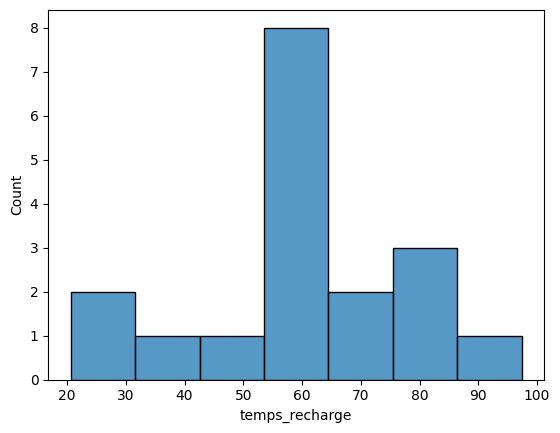

In [31]:
sns.histplot(data = temps_de_recharge["temps_recharge"]), 
plt.plot()

In [32]:
temps_de_recharge.head(3)

,date,product,machine,temps_recharge
0,2019-11-14 11:53:35+00:00,refill,A,NaN
6,2019-11-14 12:47:09+00:00,refill,B,53.57
24,2019-11-14 13:51:23+00:00,refill,C,64.23


In [33]:
print("Sur un total de", len(temps_de_recharge), "rechargements : ")
print("Rechargement le plus rapide =", round(temps_de_recharge["temps_recharge"].min(),0), "minutes")
print("Rechargement le plus lent= ", round(temps_de_recharge["temps_recharge"].max(),0), "minutes")
print("Rechargement moyen =", round(temps_de_recharge["temps_recharge"].mean(),0), "minutes")
print("Rechargement médian =", round(temps_de_recharge["temps_recharge"].median(),0), "minutes")

Sur un total de 24 rechargements : 
Rechargement le plus rapide = 21.0 minutes
Rechargement le plus lent=  97.0 minutes
Rechargement moyen = 60.0 minutes
Rechargement médian = 60.0 minutes


### Conclusion : 
Les machines sont actuellement rechargées par l'employé le jeudi entre 11h et 16h00, l'employé passe environ 1h à recharger chaque machine (repas du midi inclus étant donné la variance entre
le rechargement le plus rapide et la valeur du rechargement le plus lent).
Une question d'optimisation des temps de recharge de chaque machine par l'employé semble possible.

In [34]:
del temps_de_recharge

## Stock

### Displot par machine et par produit selon les jours de la semaine

In [35]:
# Rappel : la quantité max est de 280 pour le café, 120 pour le soda, 60 pour l'nrj drink

c:\Users\manon\anaconda3\envs\data\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\manon\AppData\Local\Temp\ipykernel_26000\33582342.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


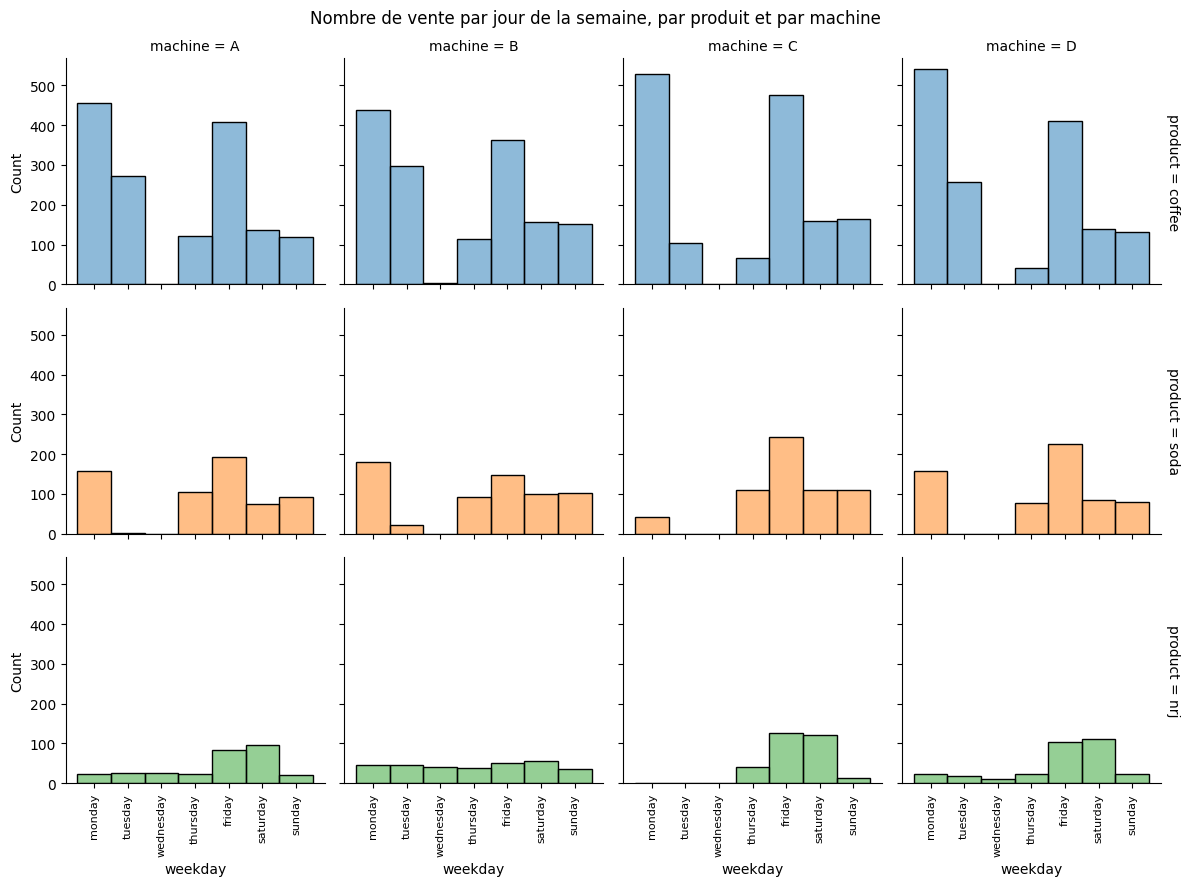

In [120]:
fig, ax = plt.figsize=(10,10)
ax = sns.displot(data=df.iloc[1217:,],
            x="weekday", 
            col="machine", 
            row="product",
            height=3,
            facet_kws=dict(margin_titles=True),
            col_order=["A", "B", "C", "D"],
            row_order=["coffee", "soda", "nrj"],
            hue="product",
            hue_order=["coffee", "soda", "nrj"], 
            legend=False)
ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.suptitle("Nombre de vente par jour de la semaine, par produit et par machine")
plt.tight_layout()
plt.show()


#### Observations :
Ce graphique est compliqué à interprêter, nous pouvons emettre quelques suppositions mais essayons d'autres manières de visualiser les données pour cela.

### Evolution stock (%) sur l'ensemble du jeu de données

In [37]:
df[["stock_coffee_A","stock_coffee_B","stock_coffee_C","stock_coffee_D"]]= 0, 0, 0, 0
df[["stock_soda_A","stock_soda_B","stock_soda_C","stock_soda_D"]]= 0, 0, 0, 0
df[["stock_nrj_A","stock_nrj_B","stock_nrj_C","stock_nrj_D"]]= 0, 0, 0, 0

In [38]:
df.tail(5)

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,...,stock_coffee_C,stock_coffee_D,stock_soda_A,stock_soda_B,stock_soda_C,stock_soda_D,stock_nrj_A,stock_nrj_B,stock_nrj_C,stock_nrj_D
11031,2019-12-25 20:10:53+00:00,nrj,A,12,25,wednesday,20,0,0,3,...,0,0,0,0,0,0,0,0,0,0
11032,2019-12-25 20:16:30+00:00,nrj,B,12,25,wednesday,20,0,0,3,...,0,0,0,0,0,0,0,0,0,0
11033,2019-12-25 20:26:35+00:00,nrj,B,12,25,wednesday,20,0,0,3,...,0,0,0,0,0,0,0,0,0,0
11034,2019-12-25 21:11:55+00:00,nrj,B,12,25,wednesday,21,0,0,3,...,0,0,0,0,0,0,0,0,0,0
11035,2019-12-25 21:43:36+00:00,nrj,A,12,25,wednesday,21,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df[["stock_coffee_A","stock_coffee_B","stock_coffee_C","stock_coffee_D"]] = round(df[["coffee_A","coffee_B","coffee_C","coffee_D"]]/280,2)*100
df[["stock_soda_A","stock_soda_B","stock_soda_C","stock_soda_D"]] = round(df[["soda_A","soda_B","soda_C","soda_D"]]/120,2)*100
df[["stock_nrj_A","stock_nrj_B","stock_nrj_C","stock_nrj_D"]] = round(df[["nrj_A","nrj_B","nrj_C","nrj_D"]]/60,2)*100

In [40]:
df.tail(5)

,date,product,machine,month,day,weekday,hour,coffee_A,soda_A,nrj_A,...,stock_coffee_C,stock_coffee_D,stock_soda_A,stock_soda_B,stock_soda_C,stock_soda_D,stock_nrj_A,stock_nrj_B,stock_nrj_C,stock_nrj_D
11031,2019-12-25 20:10:53+00:00,nrj,A,12,25,wednesday,20,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0
11032,2019-12-25 20:16:30+00:00,nrj,B,12,25,wednesday,20,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0
11033,2019-12-25 20:26:35+00:00,nrj,B,12,25,wednesday,20,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0,0.0,0.0
11034,2019-12-25 21:11:55+00:00,nrj,B,12,25,wednesday,21,0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
11035,2019-12-25 21:43:36+00:00,nrj,A,12,25,wednesday,21,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [41]:
# calculs des pourcentages de stocks restants moyens et minimaux
df["coffee_mean"] = df[["stock_coffee_A", "stock_coffee_B", "stock_coffee_C", "stock_coffee_D"]].mean(axis=1)
df["soda_mean"]= df[["stock_soda_A", "stock_soda_B", "stock_soda_C", "stock_soda_D"]].mean(axis=1)
df["nrj_mean"]= df[["stock_nrj_A", "stock_nrj_B", "stock_nrj_C", "stock_nrj_D"]].mean(axis=1)

In [42]:
# création de nouveaux df spécialisés 
coffee = df.loc[:,["date", "weekday", "machine", "stock_coffee_A","stock_coffee_B","stock_coffee_C","stock_coffee_D", "coffee_mean"]]
soda = df.loc[:,["date", "weekday", "machine", "stock_soda_A","stock_soda_B","stock_soda_C","stock_soda_D","soda_mean"]]
nrj = df.loc[:,["date", "weekday", "machine", "stock_nrj_A","stock_nrj_B","stock_nrj_C","stock_nrj_D", "nrj_mean"]]

In [43]:
# suppression des colonnes inutiles sur le df principal
df = df.drop(columns=(['coffee_A', 'soda_A', 'nrj_A', 'coffee_B', 'soda_B', 'nrj_B',
       'coffee_C', 'soda_C', 'nrj_C', 'coffee_D', 'soda_D', 'nrj_D',
       'stock_coffee_A', 'stock_coffee_B', 'stock_coffee_C', 'stock_coffee_D',
       'stock_soda_A', 'stock_soda_B', 'stock_soda_C', 'stock_soda_D',
       'stock_nrj_A', 'stock_nrj_B', 'stock_nrj_C', 'stock_nrj_D']))

In [44]:
coffee

,date,weekday,machine,stock_coffee_A,stock_coffee_B,stock_coffee_C,stock_coffee_D,coffee_mean
0,2019-11-14 11:53:35+00:00,thursday,A,100.0,0.0,0.0,0.0,25.00
1,2019-11-14 12:06:35+00:00,thursday,A,100.0,0.0,0.0,0.0,25.00
2,2019-11-14 12:07:59+00:00,thursday,A,100.0,0.0,0.0,0.0,25.00
3,2019-11-14 12:13:45+00:00,thursday,A,100.0,0.0,0.0,0.0,25.00
4,2019-11-14 12:22:35+00:00,thursday,A,99.0,0.0,0.0,0.0,24.75
...,...,...,...,...,...,...,...,...
11031,2019-12-25 20:10:53+00:00,wednesday,A,0.0,0.0,0.0,0.0,0.00
11032,2019-12-25 20:16:30+00:00,wednesday,B,0.0,0.0,0.0,0.0,0.00
11033,2019-12-25 20:26:35+00:00,wednesday,B,0.0,0.0,0.0,0.0,0.00
11034,2019-12-25 21:11:55+00:00,wednesday,B,0.0,0.0,0.0,0.0,0.00


In [45]:
df

,date,product,machine,month,day,weekday,hour,coffee_mean,soda_mean,nrj_mean
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,25.00,25.00,25.00
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,25.00,25.00,25.00
2,2019-11-14 12:07:59+00:00,soda,A,11,14,thursday,12,25.00,24.75,25.00
3,2019-11-14 12:13:45+00:00,soda,A,11,14,thursday,12,25.00,24.50,25.00
4,2019-11-14 12:22:35+00:00,coffee,A,11,14,thursday,12,24.75,24.50,25.00
...,...,...,...,...,...,...,...,...,...,...
11031,2019-12-25 20:10:53+00:00,nrj,A,12,25,wednesday,20,0.00,0.00,2.50
11032,2019-12-25 20:16:30+00:00,nrj,B,12,25,wednesday,20,0.00,0.00,2.00
11033,2019-12-25 20:26:35+00:00,nrj,B,12,25,wednesday,20,0.00,0.00,1.75
11034,2019-12-25 21:11:55+00:00,nrj,B,12,25,wednesday,21,0.00,0.00,1.25


In [ ]:
# exemple copié à supprimer ensuite 
i = 0 
plt.figure(figsize=(20,10))
plt.suptitle("Types de produit consommés selon le jour de la semaine") 
for day in heures["weekday"].cat.categories :
    i +=1
    fig_weekday = f'ax{i}'
    fig_weekday = plt.subplot(2,4,i, sharex=ax1, sharey=ax1)
    fig_weekday = sns.countplot(data=heures[heures["weekday"]==day], x="hour", hue="product")
    fig_weekday.tick_params(axis='x', rotation=90, labelsize=8)
    plt.title(str(day))   

plt.tight_layout()
plt.show()
    

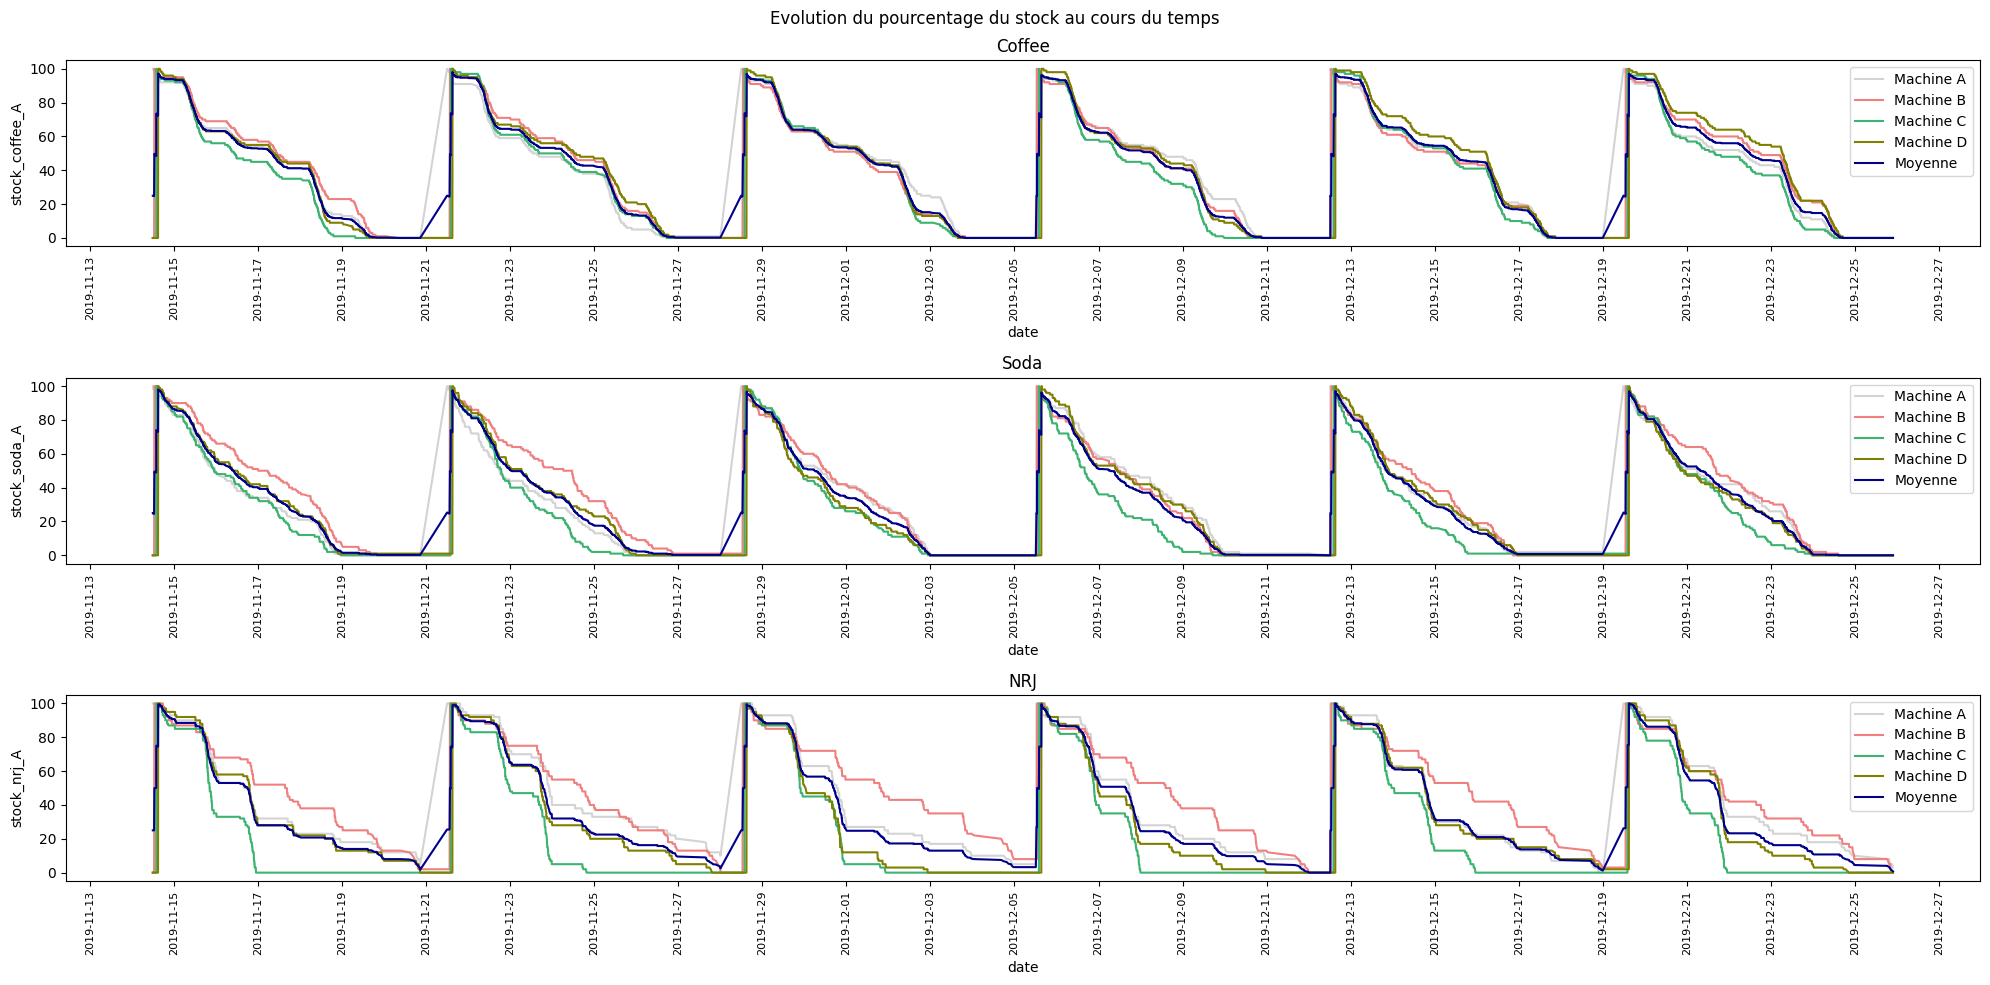

In [114]:
# penser à rajouter legende + augmenter le nombre de bins + ajouter quadrillage

plt.figure(figsize=(20,10))
loc = mdates.DayLocator(interval=2)
plt.suptitle("Evolution du pourcentage du stock au cours du temps")

ax1 = plt.subplot(3, 1, 1)
ax1 = sns.lineplot(data=coffee, x="date", y="stock_coffee_A", label="Machine A", color="lightgrey")
ax1 = sns.lineplot(data=coffee, x="date", y="stock_coffee_B", label="Machine B", color="lightcoral")
ax1 = sns.lineplot(data=coffee, x="date", y="stock_coffee_C", label="Machine C", color="mediumseagreen") 
ax1 = sns.lineplot(data=coffee, x="date", y="stock_coffee_D", label="Machine D", color="olive")
ax1 = sns.lineplot(data=coffee, x="date", y="coffee_mean", label= "Moyenne", color="darkblue")
ax1.tick_params(axis='x', rotation=90, labelsize=8)
ax1.xaxis.set_major_locator(loc)
plt.title("Coffee")

ax2 = plt.subplot(3, 1, 2)
ax2 = sns.lineplot(data=soda, x="date", y="stock_soda_A", label="Machine A", color="lightgrey")
ax2 = sns.lineplot(data=soda, x="date", y="stock_soda_B", label="Machine B", color="lightcoral")
ax2 = sns.lineplot(data=soda, x="date", y="stock_soda_C", label="Machine C", color="mediumseagreen")
ax2 = sns.lineplot(data=soda, x="date", y="stock_soda_D", label="Machine D", color="olive")
ax2 = sns.lineplot(data=soda, x="date", y="soda_mean", label= "Moyenne", color="darkblue")
ax2.tick_params(axis='x', rotation=90, labelsize=8)
ax2.xaxis.set_major_locator(loc)
plt.title("Soda")


ax3 = plt.subplot(3, 1, 3)
ax3 = sns.lineplot(data=nrj, x="date", y="stock_nrj_A", label="Machine A", color="lightgrey")
ax3 = sns.lineplot(data=nrj, x="date", y="stock_nrj_B", label="Machine B", color="lightcoral")
ax3 = sns.lineplot(data=nrj, x="date", y="stock_nrj_C", label="Machine C", color="mediumseagreen")
ax3 = sns.lineplot(data=nrj, x="date", y="stock_nrj_D", label="Machine D", color="olive")
ax3 = sns.lineplot(data=nrj, x="date", y="nrj_mean", label= "Moyenne", color="darkblue")
ax3.tick_params(axis='x', rotation=90, labelsize=8)
ax3.xaxis.set_major_locator(loc)
plt.title("NRJ")

plt.tight_layout()
plt.show()



#### Observations : 

On observe une très forte régularité de consommation quelques soient les produits / les machines.

La machine C semble être soumise à une plus forte demande que les autres machines, quelques soient les produits.

*Energy drinks* 
La consommation en energie drinks des machines A et D sont similaires, on pourrait considerer une augmentation du nombre d'emplacements d'nrj drinks
dans la machine "C" (consommation forte) en diminuant le nombre d'emplacements de sodas. 

A vérifier selon les marges faites sur chaque produit afin de savoir ce qui est le plus rentable et éventuellement de regarder s'il est 
possible de modifier la programmation de la machine deux fois par semaine (pour s'ajuster aux ventes) sans augmenter trop considérablement le 
temps passé par l'employé sur la machine. Exemple : rechargement le lundi avec 120 sodaet 60 nrj drinks, puis rechargement le jeudi avec 100 sodas et 80 nrj drinks.

### Evolution du stock (%) sur une semaine type

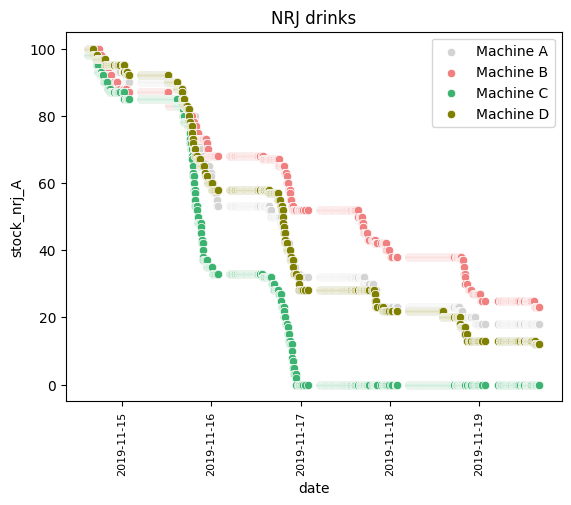

In [118]:
palette=["lightgrey", "lightcoral", "mediumseagreen", "olive"]


ax1 = sns.scatterplot(data=nrj.iloc[43:1800,:], x="date", y="stock_nrj_A", label="Machine A", color=palette[0])
ax1 = sns.scatterplot(data=nrj.iloc[43:1800,:], x="date", y="stock_nrj_B", label="Machine B", color=palette[1])
ax1 = sns.scatterplot(data=nrj.iloc[43:1800,:], x="date", y="stock_nrj_C", label="Machine C", color=palette[2])
ax1 = sns.scatterplot(data=nrj.iloc[43:1800,:], x="date", y="stock_nrj_D", label="Machine D", color=palette[3])

ax1.tick_params(axis='x', rotation=90, labelsize=8)
plt.title("NRJ drinks")
plt.show()

#### Observations : 
En date du dimanche 17 novembre 2019 la machine "C" ne contient plus d'NRJ drinks tandis que le stock de la machine "A" encore rempli à 60%

### Ventes par jour (Qte) sur la semaine "moyenne"
Les relevés de consommation semblent suffisamment réguliers (à vérifier éventuellement par un test statistique) pour créer une visualisation sur une "semaine type"

In [48]:
# diminution de la taille du df afin de manipuler moins de colonnes
heures = df.iloc[:,:7]
heures = heures[heures["product"]!= "refill"]

In [49]:
heures["weekday"] = pd.Categorical(heures["weekday"], categories=['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], ordered=True)

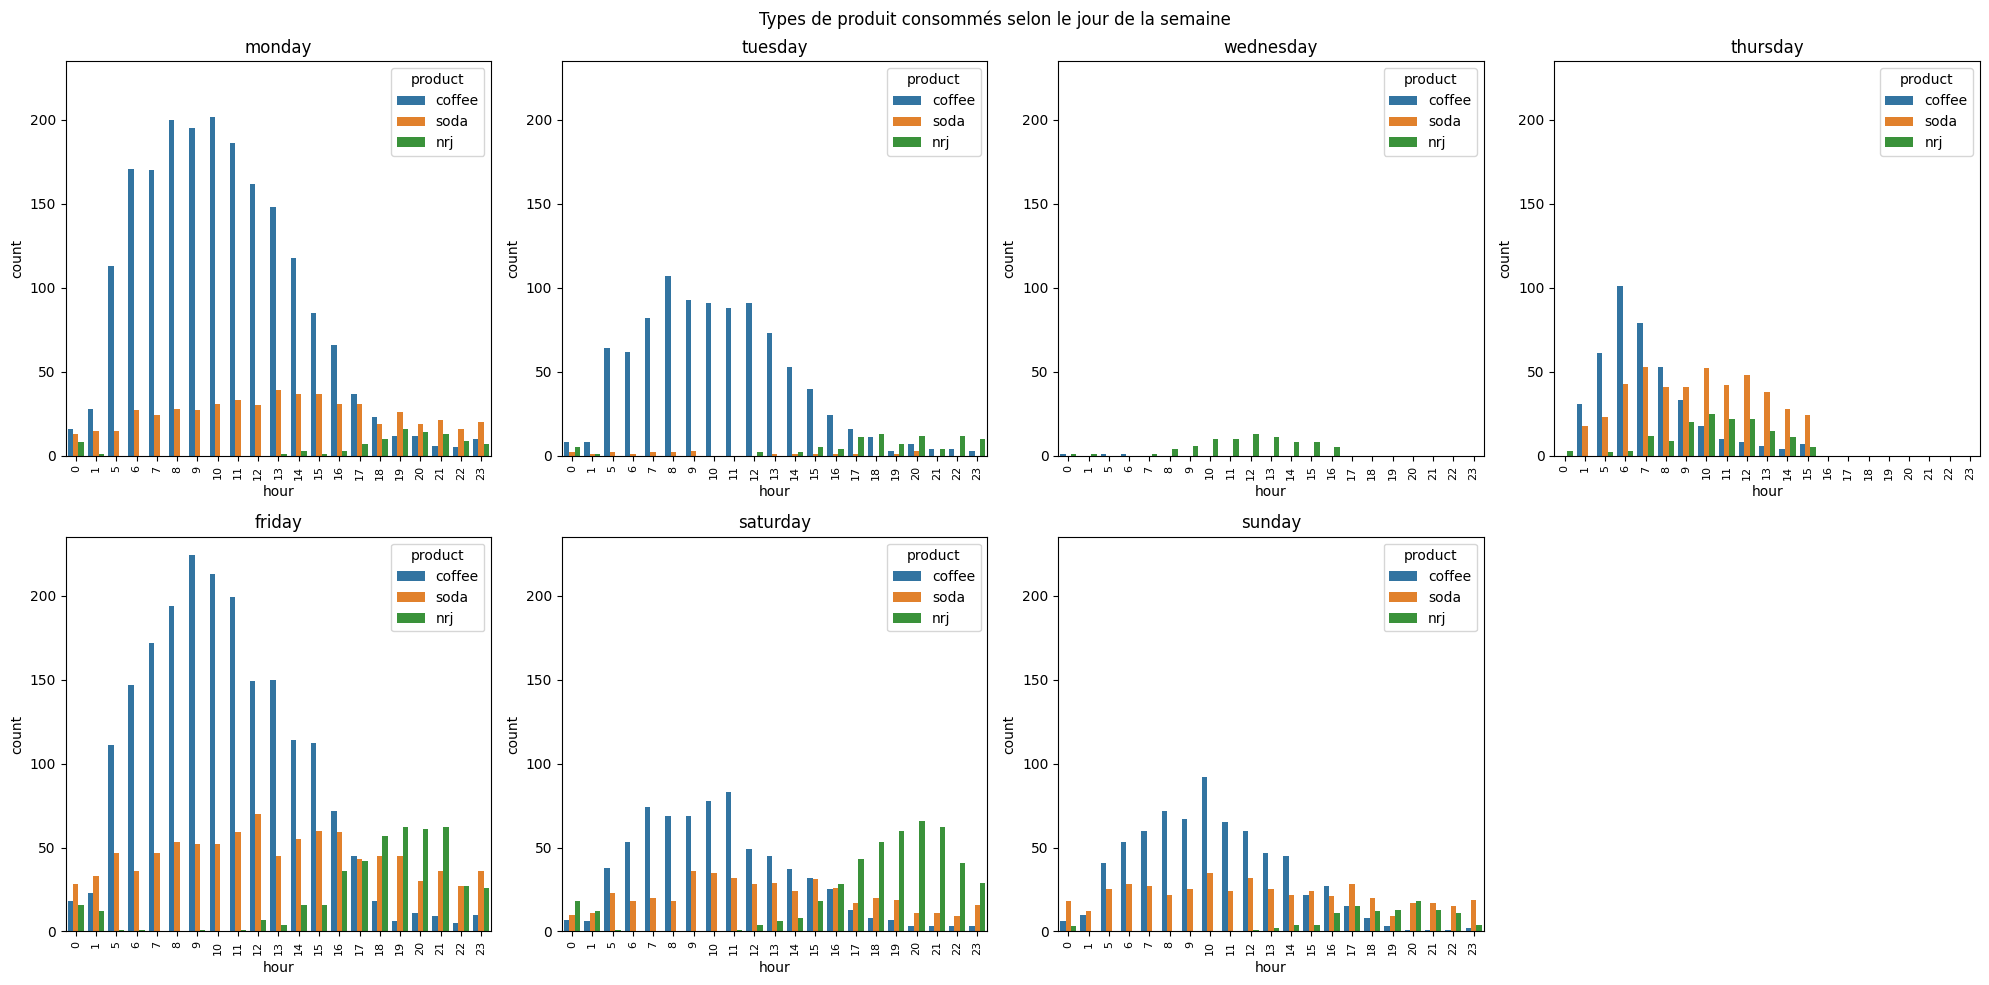

In [119]:
i = 0 
plt.figure(figsize=(20,10))
plt.suptitle("Types de produit consommés selon le jour de la semaine") 
order=["coffee", "soda", "nrj"]
for day in heures["weekday"].cat.categories :
    i +=1
    fig_weekday = f'ax{i}'
    fig_weekday = plt.subplot(2,4,i, sharex=ax1, sharey=ax1)
    fig_weekday = sns.countplot(data=heures[heures["weekday"]==day], x="hour", hue="product", hue_order=order)
    fig_weekday.tick_params(axis='x', rotation=90, labelsize=8)
    plt.title(str(day))   

plt.tight_layout()
plt.show()
    

#### Observations :
Rappel : le remplissage des machines est réalisé le jeudi entre 11 et 16h ce qui entraine que la premiere journée en "jour ouvert" analysable est le vendredi.

* Le café est essentiellement vendu en semaine entre 5h et 16h (on l'observe le lundi et le vendredi, pour des raisons de stocks insuffisants nous ne pouvons pas l'observer dans 
les mêmes proportions les autres jours de la semaine. Les samedi et dimanche on observe une consommation sur les mêmes horaires qu'en semaine mais dans des proportions moindres.
* Les nrj drinks semblent être fortement consommés les vendredi et samedi soir entre 16h et 1h. 
* Pour finir les soda semblent être consommés de manière régulière quelque soit le jour de la semaine.

### Visualisation des temps forts de consommations hebdomadaires

In [51]:
df

,date,product,machine,month,day,weekday,hour,coffee_mean,soda_mean,nrj_mean
0,2019-11-14 11:53:35+00:00,refill,A,11,14,thursday,11,25.00,25.00,25.00
1,2019-11-14 12:06:35+00:00,coffee,A,11,14,thursday,12,25.00,25.00,25.00
2,2019-11-14 12:07:59+00:00,soda,A,11,14,thursday,12,25.00,24.75,25.00
3,2019-11-14 12:13:45+00:00,soda,A,11,14,thursday,12,25.00,24.50,25.00
4,2019-11-14 12:22:35+00:00,coffee,A,11,14,thursday,12,24.75,24.50,25.00
...,...,...,...,...,...,...,...,...,...,...
11031,2019-12-25 20:10:53+00:00,nrj,A,12,25,wednesday,20,0.00,0.00,2.50
11032,2019-12-25 20:16:30+00:00,nrj,B,12,25,wednesday,20,0.00,0.00,2.00
11033,2019-12-25 20:26:35+00:00,nrj,B,12,25,wednesday,20,0.00,0.00,1.75
11034,2019-12-25 21:11:55+00:00,nrj,B,12,25,wednesday,21,0.00,0.00,1.25


In [52]:
# Création de tables pivots afin de réaliser des heatmaps
new_index= ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

df_cafe=df[df["product"]=="coffee"]
pivot_cafe = df_cafe[['product', 'weekday', 'hour']]
pivot_cafe = pd.pivot_table(pivot_cafe, values="product", index="hour", columns="weekday", aggfunc='count')
pivot_cafe = pivot_cafe.reindex(columns=new_index)

df_soda=df[df["product"]=="soda"]
pivot_soda = df_soda[['product', 'weekday', 'hour']]
pivot_soda = pd.pivot_table(pivot_soda, values="product", index="hour", columns="weekday", aggfunc='count')
pivot_soda = pivot_soda.reindex(columns=new_index)

df_nrj=df[df["product"]=="nrj"]
pivot_nrj = df_nrj[['product', 'weekday', 'hour']]
pivot_nrj = pd.pivot_table(pivot_nrj, values="product", index="hour", columns="weekday", aggfunc='count')
pivot_nrj = pivot_nrj.reindex(columns=new_index)
pivot_nrj

weekday,monday,tuesday,wednesday,thursday,friday,saturday,sunday
hour,,,,,,,
0,8.0,5.0,1.0,3.0,16.0,18.0,3.0
1,1.0,1.0,1.0,NaN,12.0,12.0,NaN
5,NaN,NaN,NaN,NaN,1.0,1.0,NaN
6,NaN,NaN,NaN,NaN,1.0,NaN,NaN
9,NaN,NaN,NaN,NaN,1.0,NaN,NaN
11,NaN,NaN,NaN,NaN,1.0,1.0,NaN
12,NaN,2.0,NaN,NaN,7.0,4.0,1.0
13,1.0,NaN,NaN,2.0,4.0,6.0,2.0
14,3.0,2.0,1.0,3.0,16.0,8.0,4.0


C:\Users\manon\AppData\Local\Temp\ipykernel_26000\346173568.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(131)


[]

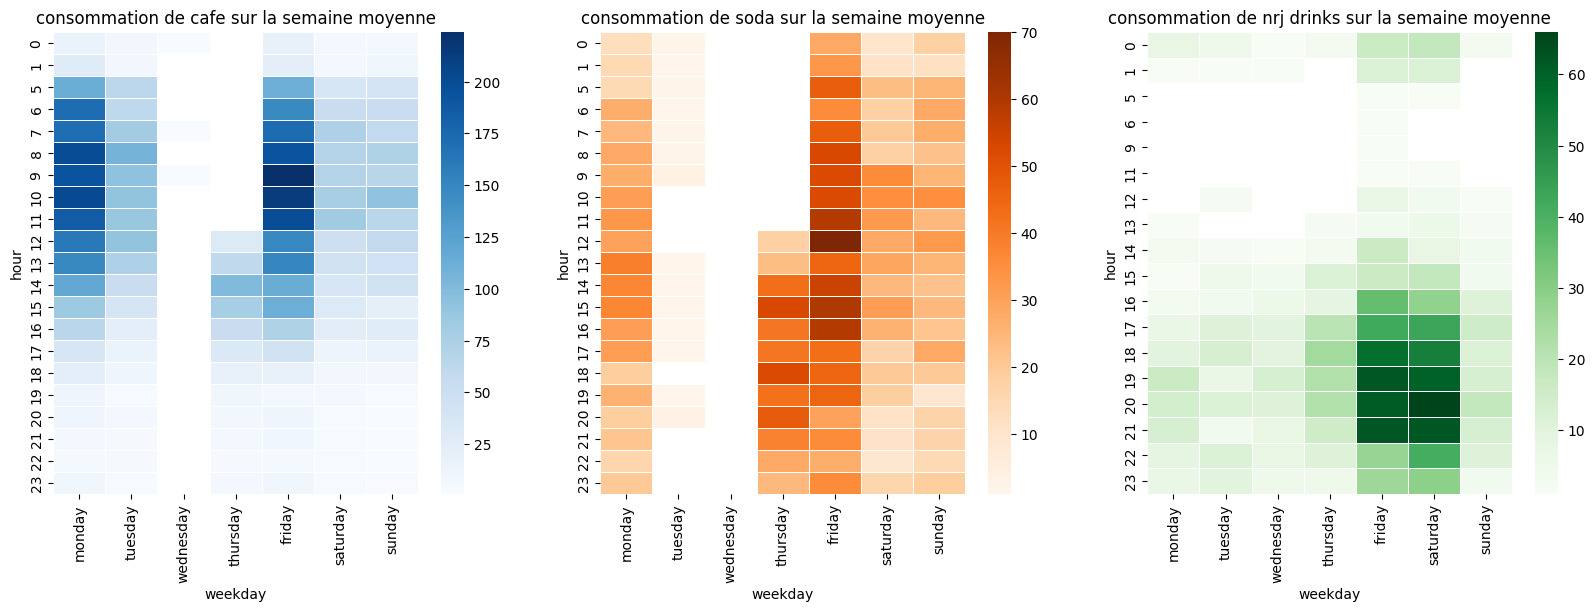

In [124]:
fig, ax = plt.subplots(figsize=(20, 6))
ax1 = plt.subplot(131)
ax1 = sns.heatmap(data = pivot_cafe, linewidths=.5, cmap="Blues")
plt.title("consommation de cafe sur la semaine moyenne")
ax2 = plt.subplot(132)
ax2 = sns.heatmap(data = pivot_soda,  linewidths=.5, cmap="Oranges")
plt.title("consommation de soda sur la semaine moyenne")
ax3 = plt.subplot(133)
ax3 = sns.heatmap(data = pivot_nrj, linewidths=.5, cmap="Greens")
plt.title("consommation de nrj drinks sur la semaine moyenne")
plt.plot()

#### Observations : 
Grace à ces graphiques nous pouvons conforter nos suppositions précédentes. Malgré tout, il faudrait améliorer la fourniture des machines afin d'avoir de pouvoir tirer des conclusions plus fiables.  

## Comptabilité

Rappels : 
* Le déplacement d'un employé coûte 50 euros pour aller à la gare + 20 euros par machine. Les 4 machines sont dans la même gare.
* Le prix de vente des boissons est de : 1 euro le café ; 1,60 euros le soda ; 1,80 euros le nrj drink.
* Le coût de revient des boissons est de : 30 cts le café ; 60 cts le soda ; 80 cts le nrj drink.
* Chaque distributeur a une capacité maximale de : 280 doses de café ; 120 canettes de soda ; 60 bouteilles de nrj drink.
* Le coût de location de l'emplacement pour chaque machine est de 150 euros mensuels.
* Les frais d'entretien de chaque machine sont de 1200 euros annuels.

### Calcul des marges

In [54]:
# Calcul des marges :
marge_coffee=round(100*1/0.3, 2)
marge_soda=round(100*1.6/1, 2)
marge_nrj=round(100*1.8/0.8, 2)
print(f'Marge réalisée sur la vente du café = {marge_coffee}%')
print(f'Marge réalisée sur la vente des sodas = {marge_soda}%')
print(f'Marge réalisée sur la vente des nrj drinks = {marge_nrj}%')

Marge réalisée sur la vente du café = 333.33%
Marge réalisée sur la vente des sodas = 160.0%
Marge réalisée sur la vente des nrj drinks = 225.0%


### Calculs couts/recettes

In [55]:
# Rappel : 52 semaines par ans = 4,3 semaine par mois.
# Etant donné que la machine est vide à chaque nouveau remplissage, le chiffre d'affaire par semaine est de : 
recettes = (280*1+120*1.6+60*1.8)*4 # 4 machines
recettes_an=recettes*52
print("Chiffre d'affaire annuel = ", recettes_an, "€")

achats = (280*0.3+120*0.6+60*0.8)*4
achats_an=achats*52
print("Prix d'achat des boissons par an = ", achats_an, "€")

employe_an = 50+4*20*52
print("Cout du déplacement de l'employé pour 1 recharge/4machines/semaine pour 1 an =", employe_an, "€")

frais_entretien_annuels_4_machines=1200*4
print("La facture annuelle d'entretien des machines est de", frais_entretien_annuels_4_machines, "€")

Chiffre d'affaire annuel =  120640.0 €
Prix d'achat des boissons par an =  42432.0 €
Cout du déplacement de l'employé pour 1 recharge/4machines/semaine pour 1 an = 4210 €
La facture annuelle d'entretien des machines est de 4800 €


In [56]:
solde_annuel = recettes_an-achats_an-employe_an-frais_entretien_annuels_4_machines
print("Le bénéfice annuel actuel est de : ", solde_annuel, "€")

Le bénéfice annuel actuel est de :  69198.0 €


## Reste à faire : 
* machine learning pour faire des prévisions de ventes avec 2 refills par semaine.
* annoter les graphiques, améliorer les 
* mettre des 0 sur les NaN des heatmaps
* les differentes solutions d'optimisation de rechargement des machines : changer le jour de rechargement,mettre deux refill/week, modifier le nombre d'emplacement max par produit selon si rechargement en debut ou fin de semaine (plus d'nrj drinks pour le week end, plus de cafe pour la semaine? )
* réfléchir aux changements de prix des produits afin de faire de meilleures marges